# Lab 5 Report:
## Stock Prediction AI with Encoder-Decoder RNN

### Name:

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

In [168]:
from IPython.display import Image # For displaying images in colab jupyter cell

In [169]:
# Image('lab5_exercise.png', width = 1000)

In [170]:
# Seaborn plot styling
sns.set(style = 'white', font_scale = 2)

## Prepare Data

In [171]:
# Load stock datasets
# Pick one of three to train your model
# Use 'closing price' column for training and testing

tesla = pd.read_csv('TSLA.csv')
tesla_np = tesla.to_numpy()

google = pd.read_csv('GOOGL.csv')
google_np = google.to_numpy()

dji = pd.read_csv('DJI.csv')
dji_np = dji.to_numpy()

In [172]:
tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


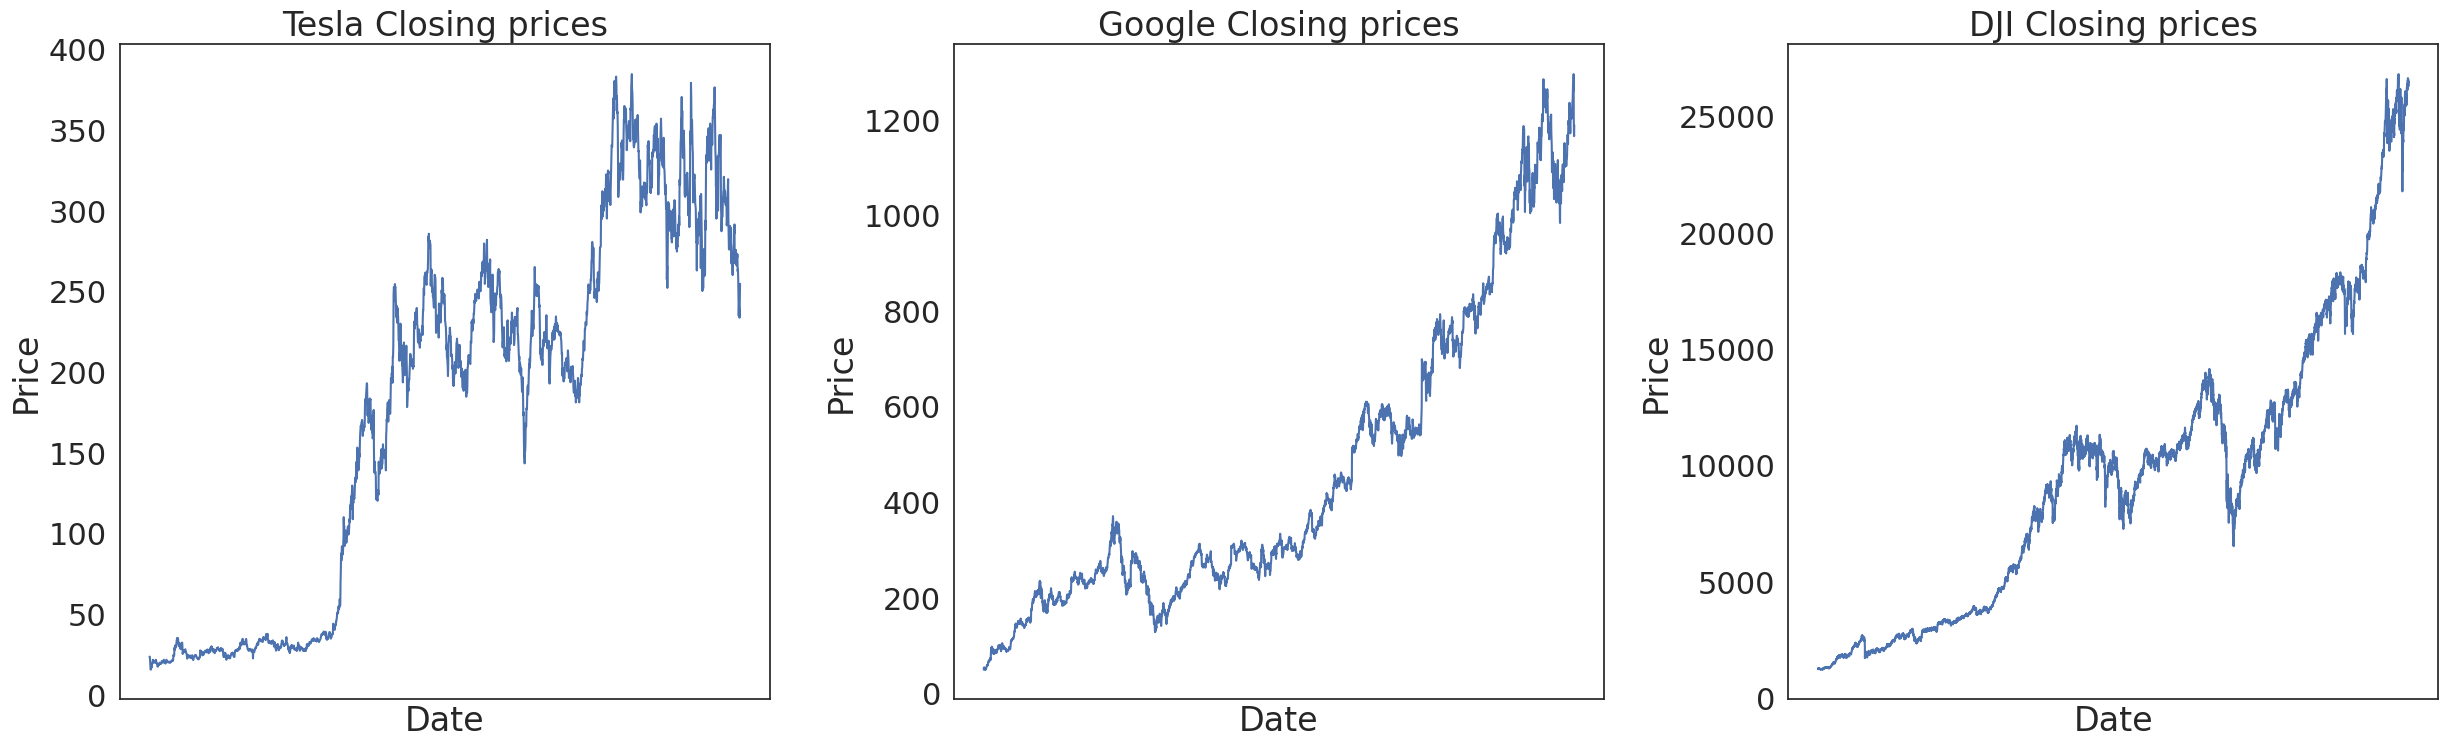

In [173]:
plt.figure(figsize = (25, 8))

plt.subplot(1, 3, 1)
plt.plot('Date', 'Close', data=tesla)
plt.title('Tesla Closing prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])

plt.subplot(1, 3, 2)
plt.plot('Date', 'Close', data=google)
plt.title('Google Closing prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])

plt.subplot(1, 3, 3)
plt.plot('Date', 'Close', data=dji)
plt.title('DJI Closing prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])

plt.tight_layout()
plt.show()

In [174]:
# Normalize your data and select training dataset (all the days except for last 100 days)

# YOUR CODE HERE

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

tesla_closes = scaler.fit_transform(tesla_np[:, 4].reshape(-1, 1))
google_closes = scaler.fit_transform(google_np[:, 4].reshape(-1, 1))
dji_closes = scaler.fit_transform(dji_np[:, 4].reshape(-1, 1))

In [175]:
print(tesla_np[:, 4], tesla_np[:, 4].shape)
tesla_closes

[23.889999 23.83 21.959999 ... 234.009995 244.100006 255.029999] (2227,)


array([[-1.32913376],
       [-1.32965451],
       [-1.34588488],
       ...,
       [ 0.49456796],
       [ 0.58214254],
       [ 0.6770076 ]])

In [176]:
def generate_input_output_seqs(y, encoder_inputseq_len, decoder_outputseq_len, stride = 1, num_features = 1):

    L = y.shape[0] # Length of y

    # Calculate how many input/target sequences there will be based on the parameters and stride
    num_samples = (L - encoder_inputseq_len - decoder_outputseq_len) // stride + 1

    # Numpy zeros arrray to contain the input/target sequences
    # Note that they should be in (num_samples, seq_len, num_features/time step) format
    train_input_seqs = np.zeros([num_samples, encoder_inputseq_len, num_features])
    train_output_seqs = np.zeros([num_samples, decoder_outputseq_len, num_features])

    # Iteratively fill in train_input_seqs and train_output_seqs
    # See slide 17 of lab 7 to get an idea of how input_seqs and output_seqs look like
    for ff in np.arange(num_features):

        for ii in np.arange(num_samples):

            start_x = stride * ii
            end_x = start_x + encoder_inputseq_len
            train_input_seqs[ii, :, ff] = y[start_x:end_x, ff]

            start_y = stride * ii + encoder_inputseq_len
            end_y = start_y + decoder_outputseq_len
            train_output_seqs[ii, :, ff] = y[start_y:end_y, ff]

    return train_input_seqs, train_output_seqs

In [177]:
# Define your encoder input sequence length, decoder output sequence length and testing sequence length
# Construct train_input_seqs and train_output_seqs according to
# encoder input sequence length and decoder output sequence length similar to example task

encoder_inputseq_len = 15
decoder_outputseq_len = 3
testing_sequence_len = 100

tesla_train = tesla_closes[:-testing_sequence_len]
google_train = google_closes[:-testing_sequence_len]
dji_train = dji_closes[:-testing_sequence_len]

tesla_train_input_seqs, tesla_train_ouput_seqs = generate_input_output_seqs(tesla_train, encoder_inputseq_len, decoder_outputseq_len)
google_train_input_seqs, google_train_ouput_seqs = generate_input_output_seqs(google_train, encoder_inputseq_len, decoder_outputseq_len)
dji_train_input_seqs, dji_train_ouput_seqs = generate_input_output_seqs(dji_train, encoder_inputseq_len, decoder_outputseq_len)

In [178]:
# Make sure train_input_seqs and train_output_seqs have correct dimensions as expected
# (sample size, sequence length, # of features / timestep)

print("Encoder Training Inputs Shape: ", tesla_train_input_seqs.shape)
print("Decoder Training Outputs Shape: ", tesla_train_ouput_seqs.shape)

Encoder Training Inputs Shape:  (2110, 15, 1)
Decoder Training Outputs Shape:  (2110, 3, 1)


## Define Model

In [179]:
class Encoder(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional):

        super(Encoder, self).__init__()

        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                                  num_layers = num_layers,
                                  batch_first = True, dropout=dropout, bidirectional=bidirectional)

    def forward(self, input_seq, hidden_state):

        out, hidden = self.lstm(input_seq, hidden_state)

        return out, hidden

class Decoder(torch.nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers, bidirectional, dropout):

        super(Decoder, self).__init__()

        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                                  num_layers = num_layers,
                                  batch_first = True, dropout=dropout, bidirectional=bidirectional)


        self.fc_decoder = torch.nn.Linear(hidden_size*2 if bidirectional else hidden_size,
                                          output_size)

    def forward(self, input_seq, encoder_hidden_states):

        lstm_out, hidden = self.lstm(input_seq, encoder_hidden_states)
        out = self.fc_decoder(lstm_out)

        return out, hidden

class Encoder_Decoder(torch.nn.Module):

    def __init__(self, input_size, hidden_size, decoder_output_size, num_layers, bidirectional=False, dropout=0.15):

        super(Encoder_Decoder, self).__init__()

        self.Encoder = Encoder(input_size = input_size, hidden_size = hidden_size,
                               num_layers = num_layers, bidirectional=bidirectional, dropout=dropout)

        self.Decoder = Decoder(input_size = input_size, hidden_size = hidden_size,
                               output_size = decoder_output_size, num_layers = num_layers, bidirectional=bidirectional, dropout=dropout)

## Define Hyperparameters

In [180]:
torch.manual_seed(2)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

Tesla_Encoder_Decoder_RNN = Encoder_Decoder(input_size = 1,
                                            hidden_size = 32,
                                            decoder_output_size = 1,
                                            num_layers = 2,
                                            bidirectional=True).to(device)

Google_Encoder_Decoder_RNN = Encoder_Decoder(input_size = 1,
                                            hidden_size = 32,
                                            decoder_output_size = 1,
                                            num_layers = 2,
                                            bidirectional=True).to(device)

DJI_Encoder_Decoder_RNN = Encoder_Decoder(input_size = 1,
                                            hidden_size = 32,
                                            decoder_output_size = 1,
                                            num_layers = 2,
                                            bidirectional=True).to(device)

learning_rate = 1e-3
epochs = 50

batchsize = 32
num_features = 1

loss_func = torch.nn.MSELoss()
tesla_optimizer = torch.optim.Adam(Tesla_Encoder_Decoder_RNN.parameters(), lr=learning_rate)
google_optimizer = torch.optim.Adam(Google_Encoder_Decoder_RNN.parameters(), lr=learning_rate*2)
dji_optimizer = torch.optim.Adam(DJI_Encoder_Decoder_RNN.parameters(), lr=learning_rate)

Tesla_Encoder_Decoder_RNN

Encoder_Decoder(
  (Encoder): Encoder(
    (lstm): LSTM(1, 32, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
  )
  (Decoder): Decoder(
    (lstm): LSTM(1, 32, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
    (fc_decoder): Linear(in_features=64, out_features=1, bias=True)
  )
)

## Identify Tracked Values

## Train Model

In [225]:
def train_model(model, optimizer, train_input_seqs_temp, train_output_seqs_temp, epochs, batchsize, decoder_outputseq_len, num_features):
  # Convert training dataset into torch tensors
  train_input_seqs = torch.from_numpy(train_input_seqs_temp).float().to(device)
  train_output_seqs = torch.from_numpy(train_output_seqs_temp).float().to(device)


  # Split the training dataset to mini-batches
  # Skipping the last mini-batch since its size can be smaller than the set batchsize
  train_batches_features = torch.split(train_input_seqs, batchsize)[:-1]
  train_batches_targets = torch.split(train_output_seqs, batchsize)[:-1]

  # Total number of mini-batches in the training set
  batch_split_num = len(train_batches_features)

  train_loss_list = []

  for epoch in range(epochs): # For each epoch

    for k in range(batch_split_num): # For each mini_batch

        # initialize hidden states to Encoder
        hidden_state = None

        # initialize empty torch tensor array to store decoder output sequence
        decoder_output_seq = torch.zeros(batchsize, decoder_outputseq_len, num_features).to(device)

        # empty gradient buffer
        optimizer.zero_grad()

        # Feed k-th mini-batch for encoder input sequences to encoder with hidden state
        encoder_output, encoder_hidden = model.Encoder(train_batches_features[k], hidden_state)
        # Re-define the resulting encoder hidden states as input hidden states to decoder
        decoder_hidden = encoder_hidden

        # Initial input to decoder is last timestep feature from the encoder input sequence
        decoder_input = train_batches_features[k][:, -1, :]
        # The extracted feature is 2D so need to add additional 3rd dimension
        # to conform to (sample size, seq_len, # of features)
        decoder_input = torch.unsqueeze(decoder_input, 2)

        # Populating the decoder output sequence
        for t in range(decoder_outputseq_len): # for each timestep in output sequence

            # Feed in the decoder_input and decoder_hidden to Decoder, get new output and hidden states
            decoder_output, decoder_hidden = model.Decoder(decoder_input, decoder_hidden)

            # Populate the corresponding timestep in decoder output sequence
            decoder_output_seq[:, t, :] = torch.squeeze(decoder_output, 2)

            # We are using teacher forcing so using the groundtruth training target as the next input
            decoder_input = train_batches_targets[k][:, t, :]

            # The extracted feature is 2D so need to add additional 3rd dimension
            # to conform to (sample size, seq_len, # of features)
            decoder_input = torch.unsqueeze(decoder_input, 2)

        # Compare the predicted decoder output sequence aginast the target sequence to compute the MSE loss
        loss = loss_func(torch.squeeze(decoder_output_seq), torch.squeeze(train_batches_targets[k]))

        # Save the loss
        train_loss_list.append(loss.item())

        # Backprop
        loss.backward()

        # Update the RNN
        optimizer.step()

    print("Averaged Training Loss for Epoch ", epoch+1,": ", np.mean(train_loss_list[-batch_split_num:]))

  return train_loss_list

In [182]:
tesla_train_loss = train_model(Tesla_Encoder_Decoder_RNN,
                               tesla_optimizer,
                               tesla_train_input_seqs,
                               tesla_train_ouput_seqs,
                               epochs,
                               batchsize//2,
                               decoder_outputseq_len,
                               num_features)

Averaged Training Loss for Epoch  1 :  0.3037792453933365
Averaged Training Loss for Epoch  2 :  0.14543859112140445
Averaged Training Loss for Epoch  3 :  0.04932989745635454
Averaged Training Loss for Epoch  4 :  0.03614852246819491
Averaged Training Loss for Epoch  5 :  0.03178228563380264
Averaged Training Loss for Epoch  6 :  0.02910530165025346
Averaged Training Loss for Epoch  7 :  0.02730066114316787
Averaged Training Loss for Epoch  8 :  0.026258021249179905
Averaged Training Loss for Epoch  9 :  0.025398920327496095
Averaged Training Loss for Epoch  10 :  0.024438282034985492
Averaged Training Loss for Epoch  11 :  0.023633759616312523
Averaged Training Loss for Epoch  12 :  0.022575393957636882
Averaged Training Loss for Epoch  13 :  0.021921010085431333
Averaged Training Loss for Epoch  14 :  0.020994313138106995
Averaged Training Loss for Epoch  15 :  0.01967721557882721
Averaged Training Loss for Epoch  16 :  0.019327462231829223
Averaged Training Loss for Epoch  17 :  0.

In [183]:
google_train_loss = train_model(Google_Encoder_Decoder_RNN,
                               google_optimizer,
                               google_train_input_seqs,
                               google_train_ouput_seqs,
                               epochs,
                               batchsize//2,
                               decoder_outputseq_len,
                               num_features)

Averaged Training Loss for Epoch  1 :  0.08535369587986809
Averaged Training Loss for Epoch  2 :  0.08725174039643337
Averaged Training Loss for Epoch  3 :  0.04388011563553716
Averaged Training Loss for Epoch  4 :  0.018636102933539535
Averaged Training Loss for Epoch  5 :  0.01720436299553642
Averaged Training Loss for Epoch  6 :  0.012857861164125748
Averaged Training Loss for Epoch  7 :  0.013408186893554688
Averaged Training Loss for Epoch  8 :  0.012262492641899112
Averaged Training Loss for Epoch  9 :  0.012669697306331986
Averaged Training Loss for Epoch  10 :  0.011967503539835889
Averaged Training Loss for Epoch  11 :  0.011856563229425124
Averaged Training Loss for Epoch  12 :  0.011612103689848092
Averaged Training Loss for Epoch  13 :  0.011558098413388507
Averaged Training Loss for Epoch  14 :  0.011086086676186824
Averaged Training Loss for Epoch  15 :  0.011077950544469266
Averaged Training Loss for Epoch  16 :  0.010665509973867822
Averaged Training Loss for Epoch  17 

In [184]:
dji_train_loss = train_model(DJI_Encoder_Decoder_RNN,
                             dji_optimizer,
                             dji_train_input_seqs,
                             dji_train_ouput_seqs,
                             epochs,
                             batchsize//2,
                             decoder_outputseq_len,
                             num_features)

Averaged Training Loss for Epoch  1 :  0.06946797348641291
Averaged Training Loss for Epoch  2 :  0.07404831923333022
Averaged Training Loss for Epoch  3 :  0.5808831321843527
Averaged Training Loss for Epoch  4 :  0.31719938957749927
Averaged Training Loss for Epoch  5 :  0.30590958719130185
Averaged Training Loss for Epoch  6 :  0.12428084020452536
Averaged Training Loss for Epoch  7 :  0.0378389669840681
Averaged Training Loss for Epoch  8 :  0.03656577450782148
Averaged Training Loss for Epoch  9 :  0.019339354858768507
Averaged Training Loss for Epoch  10 :  0.01850277643951218
Averaged Training Loss for Epoch  11 :  0.0170227601334171
Averaged Training Loss for Epoch  12 :  0.013859404374014226
Averaged Training Loss for Epoch  13 :  0.012004133601431363
Averaged Training Loss for Epoch  14 :  0.010011987050409215
Averaged Training Loss for Epoch  15 :  0.008111050236585928
Averaged Training Loss for Epoch  16 :  0.007689885488479944
Averaged Training Loss for Epoch  17 :  0.0065

## Visualize & Evaluate Model

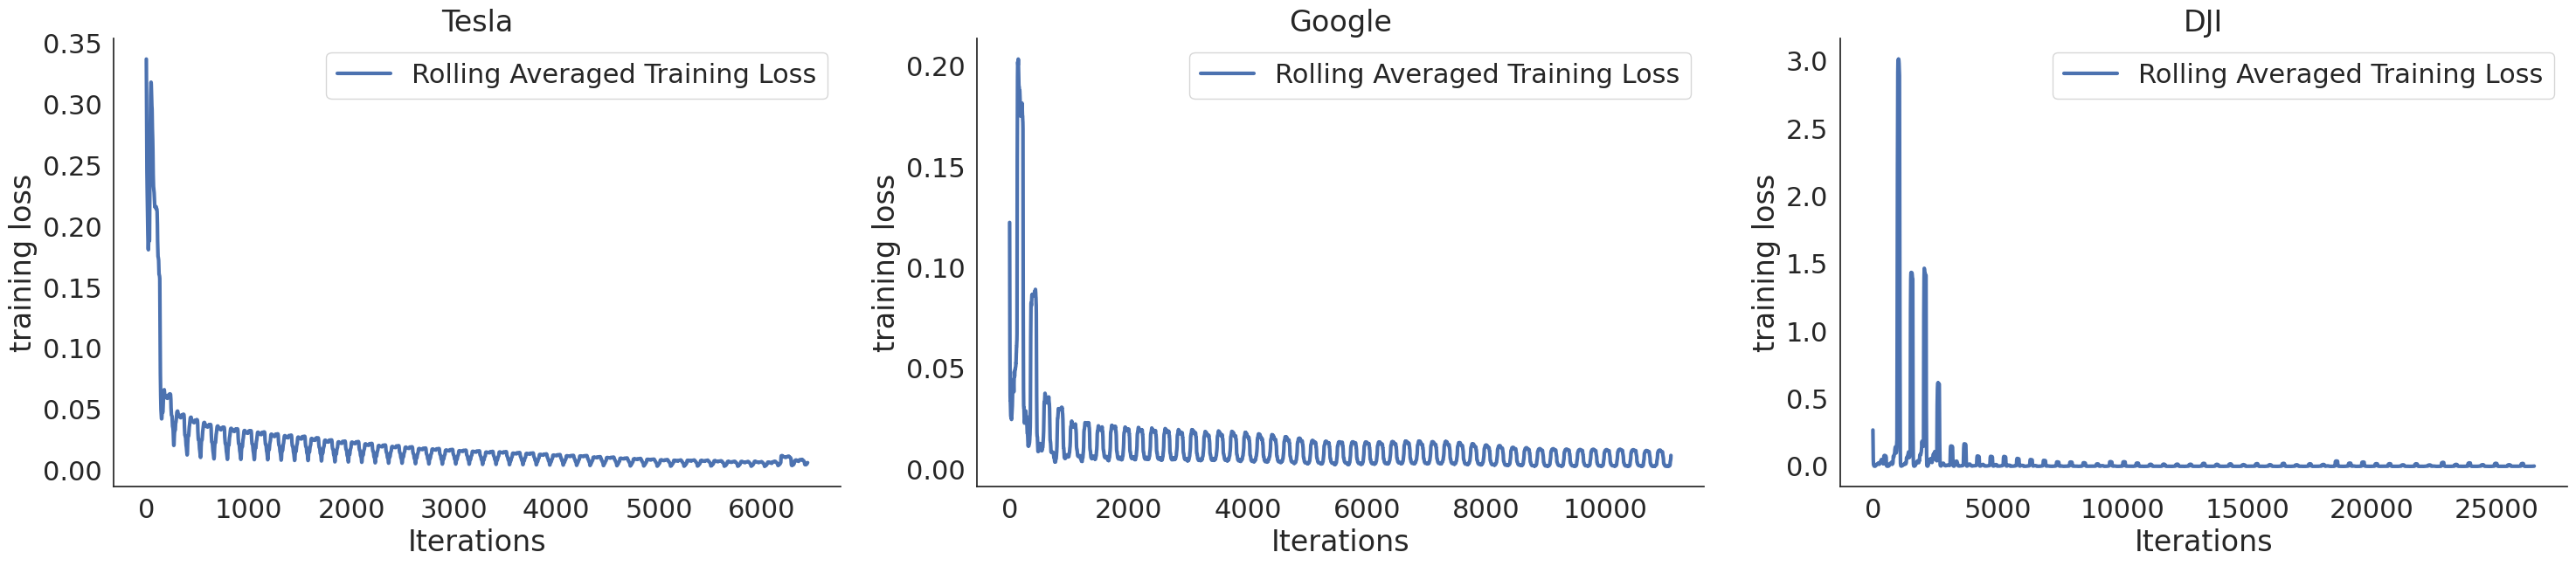

In [185]:
# YOUR CODE HERE
plt.figure(figsize = (30, 7))

plt.subplot(1, 3, 1)

plt.plot(np.convolve(tesla_train_loss, np.ones(100), 'valid') / 100,
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.title('Tesla')
plt.legend()
sns.despine()

plt.subplot(1, 3, 2)

plt.plot(np.convolve(google_train_loss, np.ones(100), 'valid') / 100,
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.title('Google')
plt.legend()
sns.despine()

plt.subplot(1, 3, 3)

plt.plot(np.convolve(dji_train_loss, np.ones(100), 'valid') / 100,
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.title('DJI')
plt.legend()
sns.despine()

plt.tight_layout()
plt.show()

In [186]:
# Define your testing sequences
tesla_test_input_seq = tesla_closes[-testing_sequence_len:]
google_test_input_seq = google_closes[-testing_sequence_len:]
dji_test_input_seq = dji_closes[-testing_sequence_len:]

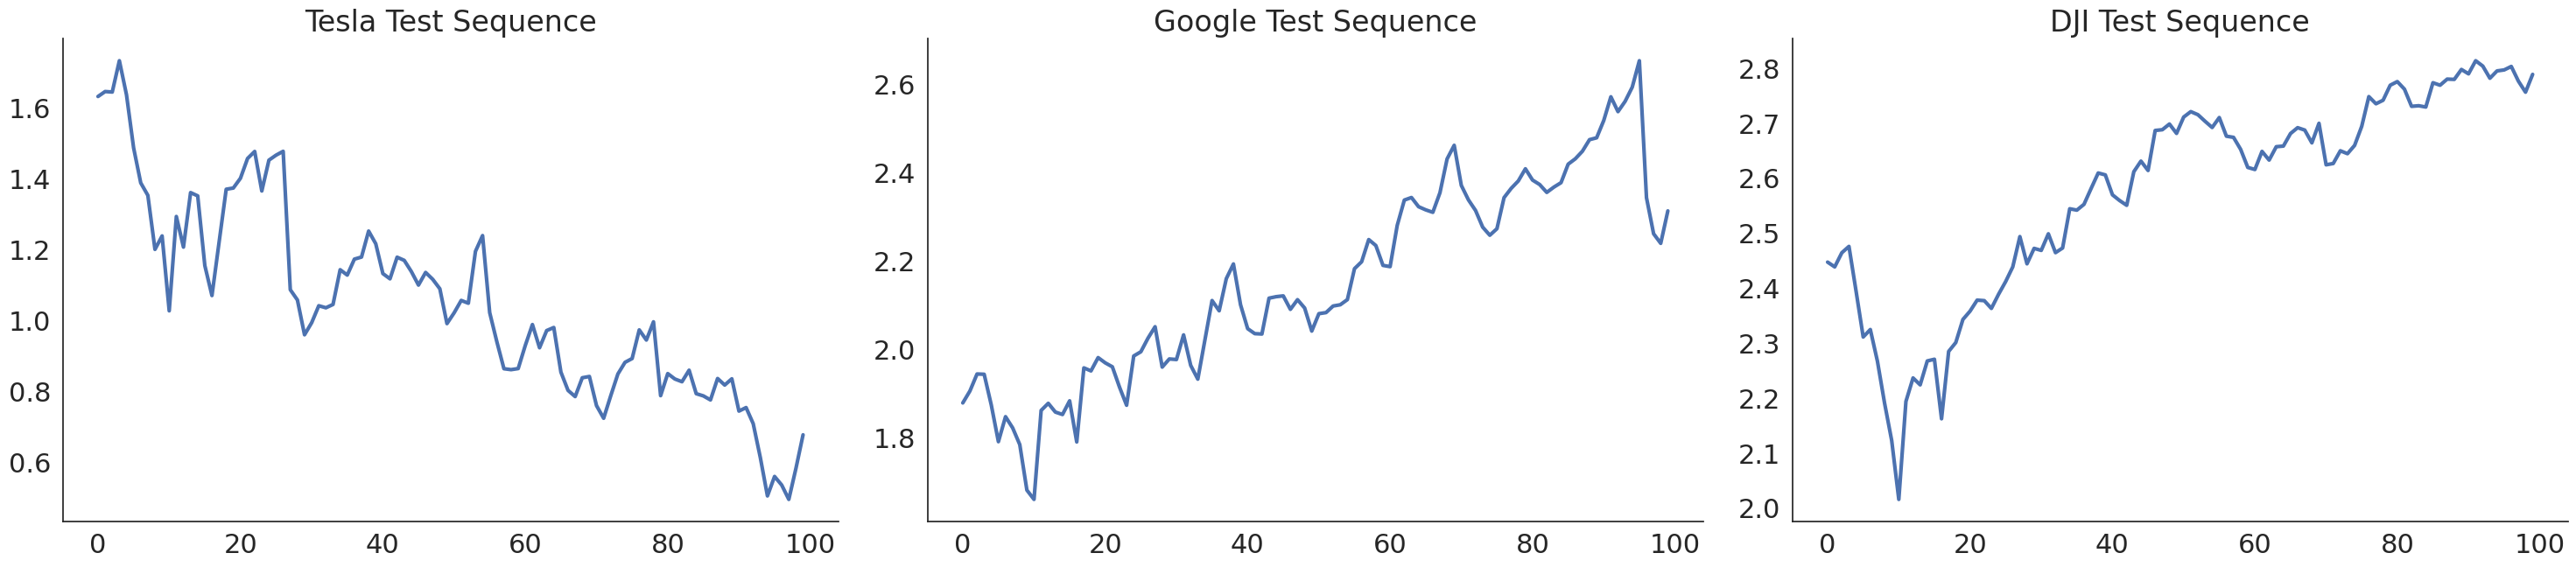

In [187]:
# Visualize the testing sequence
# Let's visualize our test sequence
plt.figure(figsize = (30, 7))

plt.subplot(1, 3, 1)
plt.plot(tesla_test_input_seq, linewidth = 3)
plt.title('Tesla Test Sequence')
sns.despine()

plt.subplot(1, 3, 2)
plt.plot(google_test_input_seq, linewidth = 3)
plt.title('Google Test Sequence')
sns.despine()

plt.subplot(1, 3, 3)
plt.plot(dji_test_input_seq, linewidth = 3)
plt.title('DJI Test Sequence')
sns.despine()

plt.tight_layout()
plt.show()


### Generate signal predictions for testing sequence with trained Encoder-Decoder

In [188]:
# USE TEACHER FORCING METHOD WHEN GENERATING OUTPUTS FROM DECODER
# When generating decoder outputs, make sure each input to decoder at timestep t has the shape (1,1,1)
# i.e., num_samples = 1, sequence_len = 1, num_features = 1

# YOUR CODE HERE

def generate_signal_prediction(model, test_input_seq, encoder_inputseq_len, decoder_outputseq_len, num_features):
  # Convert test sequence to tensor
  test_input_seq = torch.from_numpy(test_input_seq).float().to(device)

  # initialize empty torch tensor array to store decoder output sequence
  # This should be the same size as the test sequence
  decoder_output_seq = torch.zeros(testing_sequence_len, num_features)

  # First n-datapoints in decoder output sequence = First n-datapoints in ground truth test sequence
  # n = encoder_input_seq_len
  decoder_output_seq[:encoder_inputseq_len] = test_input_seq[:encoder_inputseq_len]

  # Initialize index for prediction
  pred_start_ind = 0

  # Activate no_grad() since we aren't performing backprop
  with torch.no_grad():

      # Loop continues until the RNN prediction reaches the end of the testing sequence length
      while pred_start_ind + encoder_inputseq_len + decoder_outputseq_len < testing_sequence_len:

          # initialize hidden state for encoder
          hidden_state = None

          # Define the input to encoder
          input_test_seq = decoder_output_seq[pred_start_ind:pred_start_ind + encoder_inputseq_len]
          # Add dimension to first dimension to keep the input (sample_size, seq_len, # of features/timestep)
          input_test_seq = torch.unsqueeze(input_test_seq, 0).to(device)

          # Feed the input to encoder and set resulting hidden states as input hidden states to decoder
          encoder_output, encoder_hidden = model.Encoder(input_test_seq, hidden_state)
          decoder_hidden = encoder_hidden

          # Initial input to decoder is last timestep feature from the encoder input sequence
          decoder_input = input_test_seq[:, -1, :]
          # Add dimension to keep the input (sample_size, seq_len, # of features/timestep)
          decoder_input = torch.unsqueeze(decoder_input, 2)

          # Populate decoder output sequence
          for t in range(decoder_outputseq_len):

              # Generate new output for timestep t
              decoder_output, decoder_hidden = model.Decoder(decoder_input, decoder_hidden)
              # Populate the corresponding timestep in decoder output sequence
              decoder_output_seq[pred_start_ind + encoder_inputseq_len + t] = torch.squeeze(decoder_output)
              # Use the output of the decoder as new input for the next timestep
              decoder_input = decoder_output

          # Update pred_start_ind
          pred_start_ind += decoder_outputseq_len
  return decoder_output_seq

In [189]:
decoder_output_seq_TSLA = generate_signal_prediction(Tesla_Encoder_Decoder_RNN,
                                                     tesla_test_input_seq,
                                                     encoder_inputseq_len=encoder_inputseq_len,
                                                     decoder_outputseq_len=decoder_outputseq_len,
                                                     num_features=num_features)

decoder_output_seq_GOOGLE = generate_signal_prediction(Google_Encoder_Decoder_RNN,
                                                       google_test_input_seq,
                                                       encoder_inputseq_len=encoder_inputseq_len,
                                                       decoder_outputseq_len=decoder_outputseq_len,
                                                       num_features=num_features)

decoder_output_seq_DJI = generate_signal_prediction(DJI_Encoder_Decoder_RNN,
                                                    dji_test_input_seq,
                                                    encoder_inputseq_len=encoder_inputseq_len,
                                                    decoder_outputseq_len=decoder_outputseq_len,
                                                    num_features=num_features)


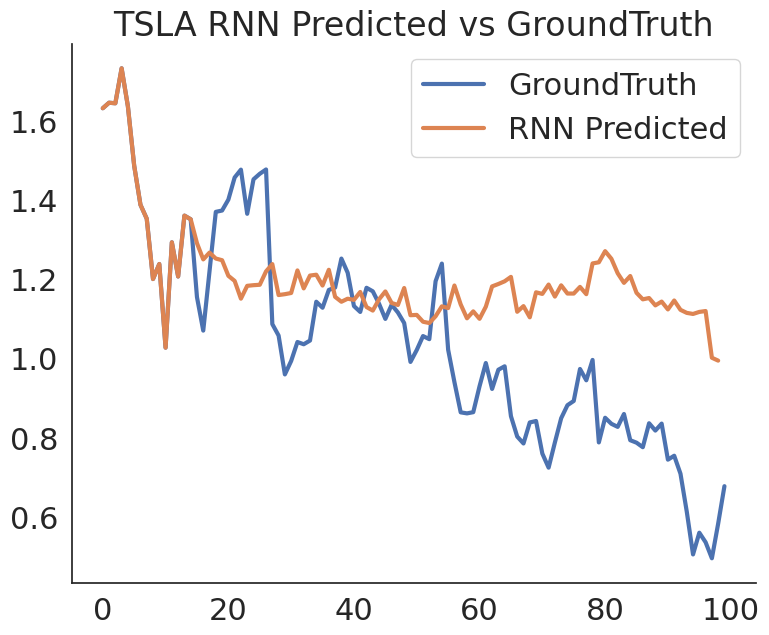

In [190]:
# Visualize predicted stock sequence vs the ground truth (TSLA)

plt.figure(figsize = (30, 7))

plt.subplot(1, 3, 1)

plt.plot(tesla_test_input_seq, linewidth = 3, label = 'GroundTruth')
plt.plot(decoder_output_seq_TSLA[:-1], linewidth = 3, label = 'RNN Predicted')
plt.title('TSLA RNN Predicted vs GroundTruth')
plt.legend()
sns.despine()



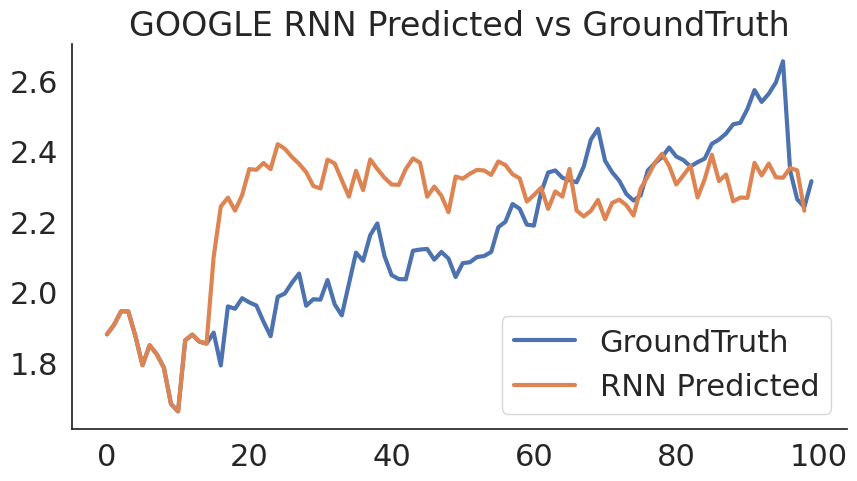

In [191]:
# Visualize predicted stock sequence vs the ground truth (GOOGLE)

plt.figure(figsize = (10, 5))

plt.plot(google_test_input_seq, linewidth = 3, label = 'GroundTruth')
plt.plot(decoder_output_seq_GOOGLE[:-1], linewidth = 3, label = 'RNN Predicted')
plt.title('GOOGLE RNN Predicted vs GroundTruth')
plt.legend()
sns.despine()

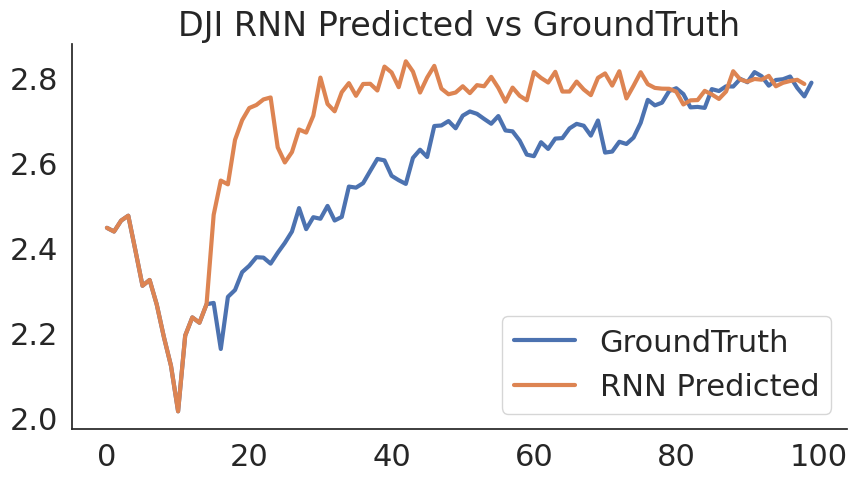

In [192]:
# Visualize predicted stock sequence vs the ground truth (DJI)

plt.figure(figsize = (10, 5))

plt.plot(dji_test_input_seq, linewidth = 3, label = 'GroundTruth')
plt.plot(decoder_output_seq_DJI[:-1], linewidth = 3, label = 'RNN Predicted')
plt.title('DJI RNN Predicted vs GroundTruth')
plt.legend()
sns.despine()

In [193]:
# Compute the MSE errors between test_input_seq and decoder_output_seq and print the value as Test MSE Error for all 3 datasets
#

# YOUR CODE HERE
tsla_test_loss = loss_func(torch.squeeze(decoder_output_seq_TSLA).to(device), torch.squeeze(torch.from_numpy(tesla_test_input_seq).float().to(device))).item()
google_test_loss = loss_func(torch.squeeze(decoder_output_seq_GOOGLE).to(device), torch.squeeze(torch.from_numpy(google_test_input_seq).float().to(device))).item()
dji_test_loss = loss_func(torch.squeeze(decoder_output_seq_DJI).to(device), torch.squeeze(torch.from_numpy(dji_test_input_seq).float().to(device))).item()

In [194]:
print(f'TSLA Test MSE Error: {tsla_test_loss}')
print(f'GOOGLE Test MSE Error: {google_test_loss}')
print(f'DJI Test MSE Error: {dji_test_loss}')

TSLA Test MSE Error: 0.06954002380371094
GOOGLE Test MSE Error: 0.09825761616230011
DJI Test MSE Error: 0.10435965657234192
